In [1]:
%matplotlib notebook
import numpy as np
from scipy import linalg
from scipy import sparse
import matplotlib.pyplot as plt

K1 = np.array([[1.,0.,0.,0.],
               [0.,2.,-1.,0,],
               [0.,-1.,2.,-1.],
               [0., 0.,-1.,1.]])

K2 = np.array([[1.,-1.,0.,0.],
               [-1.,2.,-1.,0],
               [0.,-1.,2.,0.],
               [0.,0.,0.,1.]])

M1 = 3*np.array([[1.,0.,0,],
               [0.,1.,0.],
               [0.,0.,1.]])

M2 = 3*np.array([[1.,0.,0,],
               [0.,1.,0.],
               [0.,0.,1.]])

f1 = np.array([0.,1.,1.,1.])
f2 = np.array([0.,0.,0.,0.])

B12 = np.array([[0.,0, 0,1.0]])
B21 = np.array([[-1.,0,0.0,0.]])


def local2block(matrix_list):
    
    return linalg.block_diag(*matrix_list)

def local2hblock(matrix_list):
    
    return np.hstack(matrix_list)

penalty_parameter = 1.0E1


def nonlinear(delta_u, gap0=0.0):
    force = np.zeros(delta_u.shape)
    i = 0
    for local_delta_u in delta_u:
        local_delta_u += gap0
        if local_delta_u <0.0:
            force[i] =  -penalty_parameter*local_delta_u
        else:
            force[i] = 0.0
        
        i += 1
    return force
    
   
def H(x):
    if x>=0.0:
        return 1.0
    else:
        return 0.0

def H2(x):
    alpha = 0.3
    return 1.0/(1.0+np.exp(-alpha*x))
    
def Ramp(x):
    return x*H(x)
    

def nonlinear(delta_u, gap0=0.0):
    force = np.zeros(delta_u.shape)
    for i,local_delta_u in enumerate(delta_u):
        local_delta_u -= gap0
        force[i] =  penalty_parameter*Ramp(local_delta_u)
        
    return force
 

def deriv_nonlinear(delta_u):
    if delta_u <0.0:
        return  -penalty_parameter
    else:
        return 0.0

def plot_2D_bar(nodes,connectivity,displacement=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1,1)
    
    nodes_copy = nodes.copy()
    if displacement is not None:
        u =  np.vstack([displacement,0.0*displacement]).T
        nodes_copy +=u
        
    for elem in connectivity:
        ax.plot(nodes_copy[elem].T[0],nodes_copy[elem].T[1] ,'k-')
        ax.plot(nodes_copy[elem].T[0],nodes_copy[elem].T[1] ,'ko')
        
    
alpha = 0.0001
beta = 0.0000001



<IPython.core.display.Javascript object>


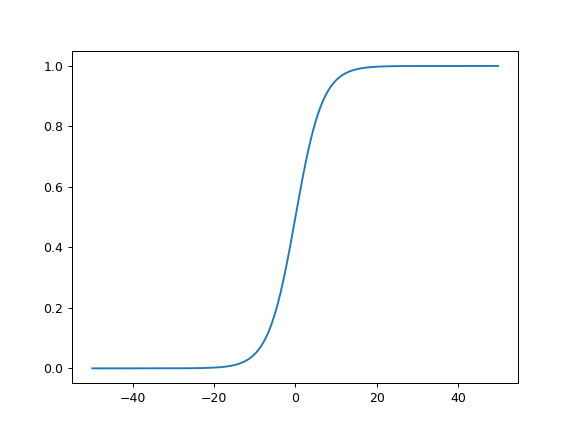

In [2]:
t = np.arange(-50,50,0.1)
plt.figure()
plt.plot(t,H2(t))
plt.show()

<IPython.core.display.Javascript object>


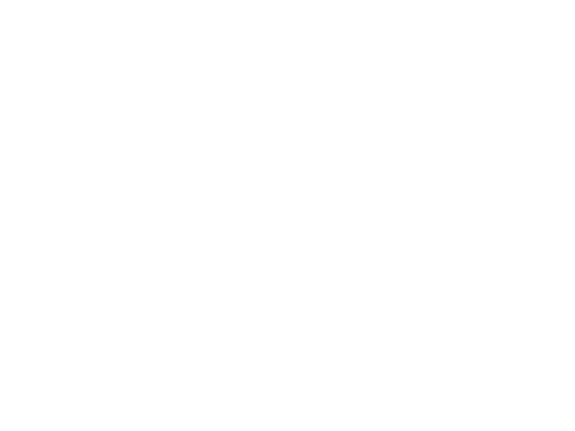

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
plt.figure()
plt.plot(t,Ramp(t))
plt.show()

In [4]:
K = local2block([K1,K2])
M = local2block([M1,M2])
B = local2hblock([B12,B21])
f = local2hblock([f1,f2])
gap0 = 1.
def R(u, f0, gap0=0.):
    r = K.dot(u) - f0 + B.T.dot(nonlinear(B.dot(u),gap0))
    #print(np.linalg.norm(r))
    return r

def create_residual (s,gap0):
    return lambda x : R(x, f0 = s*f, gap0=gap0)

s = 2.0E-1
residual = create_residual(s,gap0)
u0 = np.zeros(K.shape[0])

In [5]:
from scipy import optimize
callback = lambda x,b : print(np.linalg.norm(b))
u0 = 0.0*linalg.solve(K,s*f)

sol = optimize.root(residual,u0, method='hybr')

print(sol.success)
print(sol.x)

True
[0.         0.56721311 0.93442623 1.10163934 0.09836066 0.06557377
 0.03278689 0.        ]


In [6]:
def compute_solution_for_s(s,u0):
    residual = create_residual(s,gap0)
    sol = optimize.root(residual,u0, method='hybr')
    return sol.x

<IPython.core.display.Javascript object>


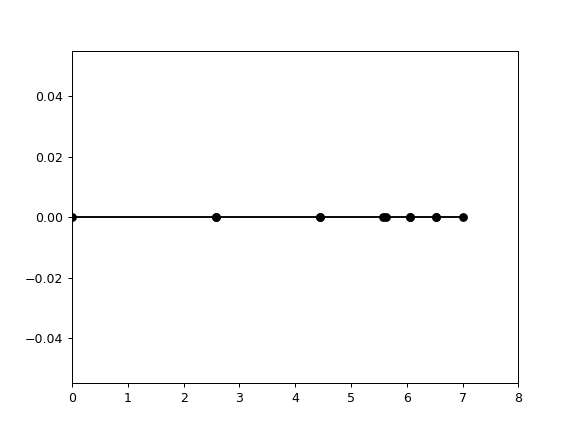

(0, 8.0)

In [7]:
s = 7.0E-1
u_sol = compute_solution_for_s(s,u0)

import matplotlib.pyplot as plt
nodes = np.array([[0.,0.],
                  [1.,0.],
                  [2.,0.],
                  [3.0, 0.],
                  [3.0 + gap0 , 0.],
                  [4.0 + gap0 , 0.],
                  [5.0 + gap0 , 0.],
                  [6.0 + gap0 , 0.]])

connectivity = np.array([[0,1],
                         [1,2],
                         [2,3],
                         [4,5],
                         [5,6],
                         [6,7]])

plot_2D_bar(nodes,connectivity,u_sol)
plt.xlim([0,7+gap0])

In [8]:
solutions = []
for i in range(100):
    u = compute_solution_for_s(i*0.005,0.0*u0)
    solutions.append(u)
    u0 = u

<IPython.core.display.Javascript object>


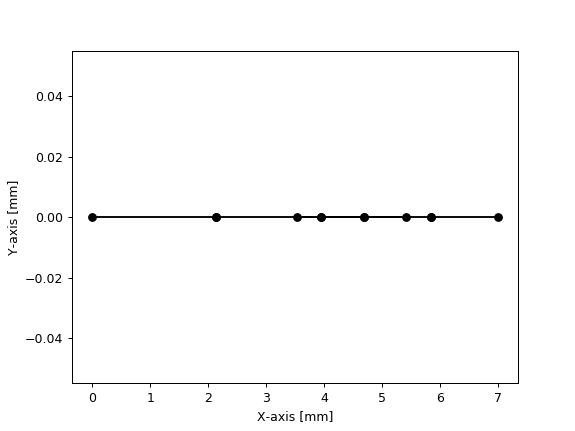

In [9]:
from matplotlib import animation, rc
fig2, ax2 = plt.subplots(1,1)
ax2.set_xlim([0,7+gap0])
ax2.legend('off')

def update(j):
    
    ax2.clear()
   
    plot_2D_bar(nodes,connectivity,solutions[j],ax=ax2)
    ax2.set_xlabel('X-axis [mm]')
    ax2.set_ylabel('Y-axis [mm]')

    
#update(10)
anim = animation.FuncAnimation(fig2, update,
                               frames=range(100), interval=10)

In [ ]:
'''
Writer =animation.writers['imagemagick']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1000)
str_res_fig = '1d_2_bars_in_contact'
git_name = str_res_fig + '.gif'
anim.save( git_name , writer=writer, dpi = 100 )
'''

In [10]:
u =  np.vstack([u_sol,0.0*u_sol]).T
u

array([[0.        , 0.        ],
       [1.57540984, 0.        ],
       [2.45081967, 0.        ],
       [2.62622951, 0.        ],
       [1.57377049, 0.        ],
       [1.04918033, 0.        ],
       [0.52459016, 0.        ],
       [0.        , 0.        ]])

In [11]:
K_inv = sparse.linalg.splu(K)
u_eval_func = lambda lm, f0 : K_inv.solve(-B.T.dot(lm)+f0)
def R_interface(lm, f0, gap0=0.):
    print(f0)
    #u_eval = K_inv.solve(-B.T.dot(lm)+f0)
    u_eval = u_eval_func(lm,f0)
    r = nonlinear(B.dot(u_eval),gap0) - lm
    #print(np.linalg.norm(r))
    return r

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [12]:
def create_residual_interface(s,gap0):
    return lambda x : R_interface(x, f0 = s*f, gap0=gap0)

In [13]:
f0 = 0.0*s*f
lm = -np.array([0.01])


In [14]:
u_eval = u_eval_func(lm,f0)
u_eval

array([ 0.  ,  0.01,  0.02,  0.03, -0.03, -0.02, -0.01,  0.  ])

In [15]:
u1 = sparse.linalg.spsolve(K1,-B12.T.dot(lm))
u1

/home/mlid150/anaconda3/envs/pyfeti/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


array([-0.  ,  0.01,  0.02,  0.03])

In [16]:
u2 = sparse.linalg.spsolve(K2,-B21.T.dot(lm))
u2

array([-0.03, -0.02, -0.01, -0.  ])

In [17]:
B.dot(u_eval)

array([0.06])

In [ ]:
B

In [18]:
nonlinear(B.dot(u_eval),gap0)

array([-0.])

In [19]:
l0 = np.array([0.18])
def compute_solution_for_s_at_interface(s,l0):
    residual = create_residual_interface(s,gap0)
    sol = optimize.root(residual,l0, method='hybr')
    #sol = optimize.minimize(residual,l0, method='Powell')
    #print(sol)
    return sol.x.reshape(1,)

In [20]:
s=0.17
f0 = s*f
lsolution = compute_solution_for_s_at_interface(s,l0)

[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0.   0.  ]
[0.   0.17 0.17 0.17 0.   0.   0. 

In [21]:
lsolution

array([0.00327869])

In [22]:
u_eval = K_inv.solve(B.T.dot(lsolution)+f0)

In [23]:
u_eval


array([ 0.        ,  0.51327869,  0.85655738,  1.02983607, -0.00983607,
       -0.00655738, -0.00327869,  0.        ])

In [24]:

usolution = compute_solution_for_s(s,0.0*u0)
usolution 

array([0.        , 0.50672131, 0.84344262, 1.01016393, 0.00983607,
       0.00655738, 0.00327869, 0.        ])

In [29]:
solutions = []
for i in range(100):
    si = i*0.005
    l_sol = compute_solution_for_s_at_interface(si,l0)
    fi = si*f
    u_sol = u_eval_func(l_sol,fi)
    solutions.append(u_sol)
    l0 = l_sol


[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0.    0.005 0.005 0.005 0.    0.    0.    0.   ]
[0.    0.005 0.005 0.005 0.    0.    0.    0.   ]
[0.    0.005 0.005 0.005 0.    0.    0.    0.   ]
[0.    0.005 0.005 0.005 0.    0.    0.    0.   ]
[0.    0.005 0.005 0.005 0.    0.    0.    0.   ]
[0.   0.01 0.01 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.01 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.01 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.01 0.01 0.   0.   0.   0.  ]
[0.   0.01 0.01 0.01 0.   0.   0.   0.  ]
[0.    0.015 0.015 0.015 0.    0.    0.    0.   ]
[0.    0.015 0.015 0.015 0.    0.    0.    0.   ]
[0.    0.015 0.015 0.015 0.    0.    0.    0.   ]
[0.    0.015 0.015 0.015 0.    0.    0.    0.   ]
[0.    0.015 0.015 0.015 0.    0.    0.    0.   ]
[0.   0.02 0.02 0.02 0.   0.   0.   0.  ]
[0.   0.02 0.02 0.02 0.   0.   0.   0.  ]
[0.   0.02 0.02 0.02 0.   0.   0.   0.  ]
[0.   0.

[0.    0.435 0.435 0.435 0.    0.    0.    0.   ]
[0.    0.435 0.435 0.435 0.    0.    0.    0.   ]
[0.    0.435 0.435 0.435 0.    0.    0.    0.   ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.   0.44 0.44 0.44 0.   0.   0.   0.  ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.    0.445 0.445 0.445 0.    0.    0.    0.   ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.   0.45 0.45 0.45 0.   0.   0.   0.  ]
[0.    0.455 0.455 0.455 0.    0.    0.    0. 

<IPython.core.display.Javascript object>


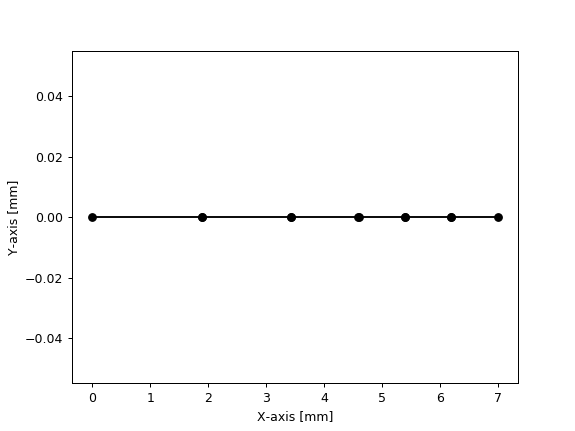

In [30]:
from matplotlib import animation, rc
fig2, ax2 = plt.subplots(1,1)
ax2.set_xlim([0,7+gap0])
ax2.legend('off')

def update(j):
    
    ax2.clear()
   
    plot_2D_bar(nodes,connectivity,solutions[j],ax=ax2)
    ax2.set_xlabel('X-axis [mm]')
    ax2.set_ylabel('Y-axis [mm]')

    
#update(10)
anim = animation.FuncAnimation(fig2, update,
                               frames=range(100), interval=10)